#### Run relevance backout here

In [59]:
import pickle
import re
import os

import random
import numpy as np
import torch
from random import shuffle
import argparse
import pickle

import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sys
sys.path.append("..")

from model.BERT import *

from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from tqdm import tqdm, trange

from util.optimization import BERTAdam
from util.processor import *


from util.tokenization import *

from util.evaluation import *

from util.train_helper import *

import logging
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s', 
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

from sklearn.metrics import classification_report

# this imports most of the helpers needed to eval the model
from run_classifier import *

sys.path.append("..")
import operator

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.rcParams["font.family"] = "Times New Roman"

#### Set-ups

In [2]:
# Note that this notebook only supports single GPU evaluation
# which is sufficient for most of tasks by using lower batch size.
IS_CUDA = False
if IS_CUDA:
    CUDA_DEVICE = "cuda:2"
    device = torch.device(CUDA_DEVICE)
    n_gpu = torch.cuda.device_count()
    logger.info("device %s in total n_gpu %d distributed training", device, n_gpu)
else:
    # bad luck, we are on CPU now!
    logger.info("gpu is out of the picture, let us use CPU")
    device = torch.device("cpu")

11/05/2020 15:25:37 - INFO - run_classifier -   gpu is out of the picture, let us use CPU


#### Indicate your folders

In [7]:
lrp_data_dir = "../../results"
vocab_data_dir = "../../models/BERT-Google/vocab.txt"

TASK_NAME = "SST5"
DATA_DIR = "../../datasets/SST5/"
            
# "../../data/uncased_L-12_H-768_A-12/" is for the default BERT-base pretrain
BERT_PATH = "../../models/BERT-Google/"
MODEL_PATH = "../../results/" + TASK_NAME + "/best_checkpoint.bin"
EVAL_BATCH_SIZE = 24 # you can tune this down depends on GPU you have.

# This loads the task processor for you.
processors = {
    "SST5":SST5_Processor
}

processor = processors[TASK_NAME]()
label_list = processor.get_labels()

In [8]:
model, tokenizer, optimizer = \
    load_model_setups(vocab_file=BERT_PATH + "vocab.txt",
                       bert_config_file=BERT_PATH + "bert_config.json",
                       init_checkpoint=MODEL_PATH,
                       label_list=label_list,
                       num_train_steps=20,
                       do_lower_case=True,
                       # below is not required for eval
                       learning_rate=2e-5,
                       warmup_proportion=0.1,
                       init_lrp=True)
model = model.to(device) # send the model to device

11/05/2020 15:37:22 - INFO - util.train_helper -   model = BERT
11/05/2020 15:37:22 - INFO - util.train_helper -   *** Model Config ***
11/05/2020 15:37:22 - INFO - util.train_helper -   {
  "attention_probs_dropout_prob": 0.1,
  "full_pooler": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



init_weight = True
init_lrp = True


In [9]:
test_examples = processor.get_test_examples(DATA_DIR)
test_features = \
    convert_examples_to_features(
        test_examples,
        label_list,
        512,
        tokenizer)

all_input_ids = torch.tensor([f.input_ids for f in test_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in test_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in test_features], dtype=torch.long)
all_label_ids = torch.tensor([f.label_id for f in test_features], dtype=torch.long)
all_seq_len = torch.tensor([[f.seq_len] for f in test_features], dtype=torch.long)

test_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                          all_label_ids, all_seq_len)
test_dataloader = DataLoader(test_data, batch_size=EVAL_BATCH_SIZE, shuffle=False)

 14%|█▍        | 309/2210 [00:00<00:00, 3088.15it/s]

0
guid= test-0
text_a= no movement , no yuks , not much of anything .
text_b= None
label= 1


100%|██████████| 2210/2210 [00:00<00:00, 2952.68it/s]


#### Call evaluation loop to get accuracy and attribution scores

In [11]:
# we did not exclude gradients, for attribution methods
model.eval() # this line will deactivate dropouts
test_loss, test_accuracy = 0, 0
nb_test_steps, nb_test_examples = 0, 0
pred_logits = []
actual = []

lrp_scores = []
lat_scores = []
inputs_ids = []
seqs_lens = []

# we don't need gradient in this case.
for _, batch in enumerate(tqdm(test_dataloader, desc="Iteration")):
    input_ids, input_mask, segment_ids, label_ids, seq_lens = batch
    # truncate to save space and computing resource
    max_seq_lens = max(seq_lens)[0]
    input_ids = input_ids[:,:max_seq_lens]
    input_mask = input_mask[:,:max_seq_lens]
    segment_ids = segment_ids[:,:max_seq_lens]

    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    label_ids = label_ids.to(device)
    seq_lens = seq_lens.to(device)

    # intentially with gradient
    tmp_test_loss, logits, all_encoder_attention_scores, embedding_output = \
        model(input_ids, segment_ids, input_mask, seq_lens,
                device=device, labels=label_ids)

    # for lrp
    LRP_class = len(label_list) - 1
    Rout_mask = torch.zeros((input_ids.shape[0], len(label_list))).to(device)
    Rout_mask[:, LRP_class] = 1.0
    relevance_score = logits*Rout_mask
    lrp_score = model.backward_lrp(relevance_score).sum(dim=-1).cpu().data
    input_ids = input_ids.cpu().data
    seq_lens = seq_lens.cpu().data
    lrp_scores.append(lrp_score)
    inputs_ids.append(input_ids)
    seqs_lens.append(seq_lens)

    # for gradient

    # for attention only tracing
    attention_scores = lat(all_encoder_attention_scores)
    lat_scores.append(attention_scores)
    
    logits = F.softmax(logits, dim=-1)
    logits = logits.detach().cpu().numpy()
    pred_logits.append(logits)
    label_ids = label_ids.to('cpu').numpy()
    actual.append(label_ids)
    outputs = np.argmax(logits, axis=1)
    tmp_test_accuracy=np.sum(outputs == label_ids)

    test_loss += tmp_test_loss.mean().item()
    test_accuracy += tmp_test_accuracy

    nb_test_examples += input_ids.size(0)
    nb_test_steps += 1

test_loss = test_loss / nb_test_steps
test_accuracy = test_accuracy / nb_test_examples

result = collections.OrderedDict()
result = {'test_loss': test_loss,
            str(len(label_list))+ '-class test_accuracy': test_accuracy}
logger.info("***** Eval results *****")
for key in result.keys():
    logger.info("  %s = %s\n", key, str(result[key]))
# get predictions needed for evaluation
pred_logits = np.concatenate(pred_logits, axis=0)
actual = np.concatenate(actual, axis=0)
pred_label = np.argmax(pred_logits, axis=-1)

lrp_state_dict = dict()
lrp_state_dict["lrp_scores"] = lrp_scores
lrp_state_dict["inputs_ids"] = inputs_ids
lrp_state_dict["seqs_lens"] = seqs_lens
lrp_state_dict["lat_scores"] = lat_scores

logger.info("***** Finish Attribution Backouts *****")

Iteration: 100%|██████████| 93/93 [04:27<00:00,  2.88s/it]
11/05/2020 15:43:09 - INFO - run_classifier -   ***** Eval results *****
11/05/2020 15:43:09 - INFO - run_classifier -     test_loss = 1.058623307494707

11/05/2020 15:43:09 - INFO - run_classifier -     5-class test_accuracy = 0.5710407239819004

11/05/2020 15:43:09 - INFO - run_classifier -   ***** Finish LRP *****


#### Aggregated lrp scores on a token aggregated across a dataset

SST-5

In [82]:
def lat(attention_probs):
    # backing out using the quasi-attention
    attention_scores = torch.zeros_like(input_ids, dtype=torch.float)
    attention_scores[:,0] = 1.
    attention_scores = torch.stack(12 * [attention_scores], dim=1).unsqueeze(dim=2)
    for i in reversed(range(12)):
        attention_scores = torch.matmul(attention_scores, attention_probs[i])
    attention_scores = attention_scores.sum(dim=1).squeeze(dim=1).data
    attention_scores = attention_scores / torch.max(attention_scores)
    return attention_scores

def inverse_mapping(vocab_dict):
    inverse_vocab_dict = {}
    for k, v in vocab_dict.items():
        inverse_vocab_dict[v] = k
    return inverse_vocab_dict

def translate(token_ids, vocab):
    tokens = []
    for _id in token_ids.tolist():
        tokens.append(vocab[_id])
    return tokens

def load_attribution_scores(vocab_data_dir, inputs_ids, seqs_lens, raw_attribution_scores):
    vocab = inverse_mapping(load_vocab(vocab_data_dir, pretrain=False))
    word_lrp = {}
    word_lrp_list = []
    sentence_lrp = []
    for batch_idx in range(len(inputs_ids)):
        for seq_idx in range(inputs_ids[batch_idx].shape[0]):
            seq_len = seqs_lens[batch_idx][seq_idx].tolist()[0]
            tokens = translate(inputs_ids[batch_idx][seq_idx], vocab)[:seq_len]
            attribution_scores = raw_attribution_scores[batch_idx][seq_idx][:seq_len]
            sentence_attribution_scores = (attribution_scores[1:-2] / torch.max(attribution_scores[1:-2])).tolist()
            sentence_lrp.append(list(zip(tokens[1:-2], sentence_attribution_scores)))
            for i in range(len(tokens)):
                word_lrp_list.append((tokens[i], attribution_scores[i]))
                if tokens[i] in word_lrp.keys():
                    word_lrp[tokens[i]].append(attribution_scores[i])
                else:
                    word_lrp[tokens[i]] = [attribution_scores[i]]
    filter_word_lrp = {}
    for k, v in word_lrp.items():
        if len(v) > 1:
            filter_word_lrp[k] = sum(v)*1.0/len(v)
    filter_word_lrp = [(k, v) for k, v in filter_word_lrp.items()] 
    filter_word_lrp.sort(key = lambda x: x[1], reverse=True)  
    word_lrp_list.sort(key = lambda x: x[1], reverse=True)
    
    return filter_word_lrp, word_lrp_list, sentence_lrp

def heatmap_viz(token_grad, vmin=0, vmax=1, cmap="Blues"):
    scores = [tu[1] for tu in token_grad]
    tokens = [tu[0] for tu in token_grad]
    fig, ax = plt.subplots(figsize=(10,1))
    ax = sns.heatmap([scores], cmap=cmap, xticklabels=tokens, yticklabels=False,
                     cbar_kws=dict(shrink=1, aspect=4, ), linewidths=0.8, vmin=vmin, vmax=vmax)
    ax.set_xticklabels(tokens, size = 18)
    cbar = ax.collections[0].colorbar
    # here set the labelsize by 20
    cbar.ax.tick_params(labelsize=20)
    plt.show()

In [83]:
word_dict_scores, word_list_scores, sentence_lrp = \
    load_attribution_scores(vocab_data_dir, 
                            lrp_state_dict["inputs_ids"], 
                            lrp_state_dict["seqs_lens"],
                            lrp_state_dict["lat_scores"])

In [84]:
word_dict_scores[:20]

[('[CLS]', tensor(0.1637)),
 ('[SEP]', tensor(0.0400)),
 ('.', tensor(0.0371)),
 ('amazingly', tensor(0.0320)),
 ('repetitive', tensor(0.0291)),
 ('requires', tensor(0.0291)),
 ('embarrassing', tensor(0.0288)),
 ('quietly', tensor(0.0285)),
 ('fits', tensor(0.0285)),
 ('observed', tensor(0.0282)),
 ('clocks', tensor(0.0281)),
 ('reveals', tensor(0.0279)),
 ('geek', tensor(0.0277)),
 ('masterpiece', tensor(0.0277)),
 ('blur', tensor(0.0275)),
 ('wreck', tensor(0.0274)),
 ('##fied', tensor(0.0273)),
 ('in', tensor(0.0272)),
 ('lifeless', tensor(0.0272)),
 ('marvelous', tensor(0.0271))]

In [85]:
word_dict_scores[-20:]

[('ol', tensor(0.0171)),
 ('fuller', tensor(0.0171)),
 ('##ny', tensor(0.0170)),
 ('##lich', tensor(0.0170)),
 ('##nik', tensor(0.0170)),
 ('##ough', tensor(0.0170)),
 ('ops', tensor(0.0169)),
 ('pluto', tensor(0.0168)),
 ('##ess', tensor(0.0168)),
 ('auto', tensor(0.0168)),
 ('ala', tensor(0.0167)),
 ('##ods', tensor(0.0167)),
 ('civil', tensor(0.0166)),
 ('lovers', tensor(0.0164)),
 ('za', tensor(0.0162)),
 ('##uber', tensor(0.0161)),
 ('plum', tensor(0.0159)),
 ('kidd', tensor(0.0158)),
 ('anthony', tensor(0.0155)),
 ('hopkins', tensor(0.0132))]

In [90]:
sentence_lrp[300]

[('time', 0.7648717761039734),
 ('change', 0.7658482193946838),
 ('##r', 0.7352558970451355),
 ('may', 0.7656140923500061),
 ('not', 0.7919691801071167),
 ('be', 0.795695960521698),
 ('the', 0.9707114696502686),
 ('most', 0.7809598445892334),
 ('memorable', 0.8501444458961487),
 ('cinema', 0.7827278971672058),
 ('session', 0.7860646843910217),
 ('but', 0.8116010427474976),
 ('its', 0.7560173273086548),
 ('profound', 0.8564774394035339),
 ('self', 0.784490168094635),
 ('evaluation', 0.7790082097053528),
 ('message', 0.8286665081977844),
 ('about', 0.7785549163818359),
 ('our', 0.7793787717819214),
 ('fragile', 0.8516889214515686),
 ('existence', 0.8701784610748291),
 ('and', 0.8645128011703491),
 ('the', 1.0),
 ('absence', 0.830861508846283),
 ('of', 0.8779792189598083),
 ('spiritual', 0.8069813251495361),
 ('guidance', 0.8318961262702942),
 ('should', 0.808224618434906),
 ('at', 0.8545145988464355),
 ('least', 0.7949985861778259),
 ('invade', 0.7993617653846741),
 ('an', 0.800391018390

11/05/2020 16:05:54 - WARNING - matplotlib.font_manager -   findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


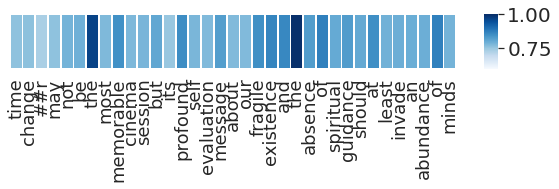

In [89]:
heatmap_viz(sentence_lrp[300], vmin=0.6, vmax=1)